In [1]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
from tabulate import tabulate
import time

# Primeiro exercício

In [12]:
def cte_1(x):
    return 1

In [13]:
def x_func(x):
    return x

In [14]:
def x_square(x):
    return x**2

In [15]:
def log(x):
    return np.log10(x)

In [22]:
def f(x,alpha,*func):
    result = 0
    for i,j in enumerate(func):
        result += alpha[i]*j(x)
    return result

In [48]:
def bracket_fi_fj(x,f_i,f_j):
    bracket = 0
    for k in x:
        bracket += f_i(k)*f_j(k)
    return bracket

In [49]:
def bracket_fi_y(x,y,f_i):
    bracket = 0
    for i,k in enumerate(x):
        bracket += f_i(k)*y[i]
    return bracket
    

In [72]:
def coef_matrix(x,n_param,funcs):
    matrix = [([0]*n_param) for i in range(n_param)]
    for i in range(n_param):
        for j in range(i,n_param):
            matrix[i][j] = matrix[j][i] = bracket_fi_fj(x,funcs[i],funcs[j])
    
    return matrix

In [73]:
def equal_vector(x,y,n_param,funcs):
    vector = []
    for i in range(n_param):
        vector.append(bracket_fi_y(x,y,funcs[i]))
    return vector

In [74]:
def eliminacaoGauss(A, y, m, print_a = False, print_y = False):
  # 1ª parte (escalonamento na forma triangular superior)
    for j in range(0,m):
        k=j+1
        if (A[j][j] == 0):
            while (k!=m-1):
                if (A[k][j] != 0):
                    #Troca X
                    aux = A[k]
                    A[k] = A[j]
                    A[j] = aux
                    #Troca Y
                    aux = y[j]
                    y[j] = y[k]
                    y[k] = aux
                    print("Troca:",A) 
                    break
                elif(k==m-1):
                    print("Erro: A matriz A é singular")
                    return
                else:
                    k+=1
        
        for i in range(j+1,m):
            mu = -A[i][j]/A[j][j]
            y[i] = y[i]+mu*y[j]
            for l in range(j,m):
                A[i][l] = A[i][l]+mu*A[j][l]
    if print_a:
        print(A)
    if print_y:    
        print(y)
        
# 2ª parte (substituição)
    x= np.zeros(m)
    
    
    x[m-1] = y[m-1]/A[m-1][m-1]
    for i in range(m-2,-1, -1):
        x[i] = y[i]
        for k in range(i+1,m):
            x[i] = x[i]-A[i][k]*x[k]
        x[i] = x[i]/A[i][i]
    return x

In [2]:
#Dados

#Profundidade em metros
x = [10.4,11.7,12.8,13,15.7,16.3,18,18.7,20.7,22.1,122.4,24.4,25.8,32.5,33.6,36.8,37.8,36.9,42.2,47,47.1,48.4,49.4,49.5,59.2,60.1,61.7,62.4,69.3,73.6,74.4,78.5,82.9,87.7,88.1,90.4,90.6,97.7,103.7]


#Porcentagem de lodo para uma profundidade x
y = [19.5,24.9,36.1,40.9,26.5,32.2,55.3,36.8,54.4,41.5,27.8,29,53.6,69.8,43.1,52.7,50.7,47.4,50.4,45.1,53.5,48,55.4,54.7,45.2,52.7,46.9,49.7,44.9,51.6,49.5,48.5,52.1,47.3,45.6,48.9,53.8,48.0,47.8]

In [100]:
funcs = [cte_1,x_func,x_square,log]
coef_mat = coef_matrix(x,4,funcs)
equal_vec = equal_vector(x,y,4,funcs)
alpha = eliminacaoGauss(coef_mat, equal_vec, 4)
index = [i for i in range(1,5)]

print(tabulate([np.append(['alpha_i'],alpha)],headers = np.append(['i'],index),tablefmt='grid',numalign="right", floatfmt = ".17f"))

+---------+-----------------------+----------------------+---------------------+----------------------+
| i       |                     1 |                    2 |                   3 |                    4 |
+=========+=======================+======================+=====================+======================+
| alpha_i | -44.73927718246941510 | -0.67232046424108016 | 0.00019802587753111 | 76.71732247427452478 |
+---------+-----------------------+----------------------+---------------------+----------------------+


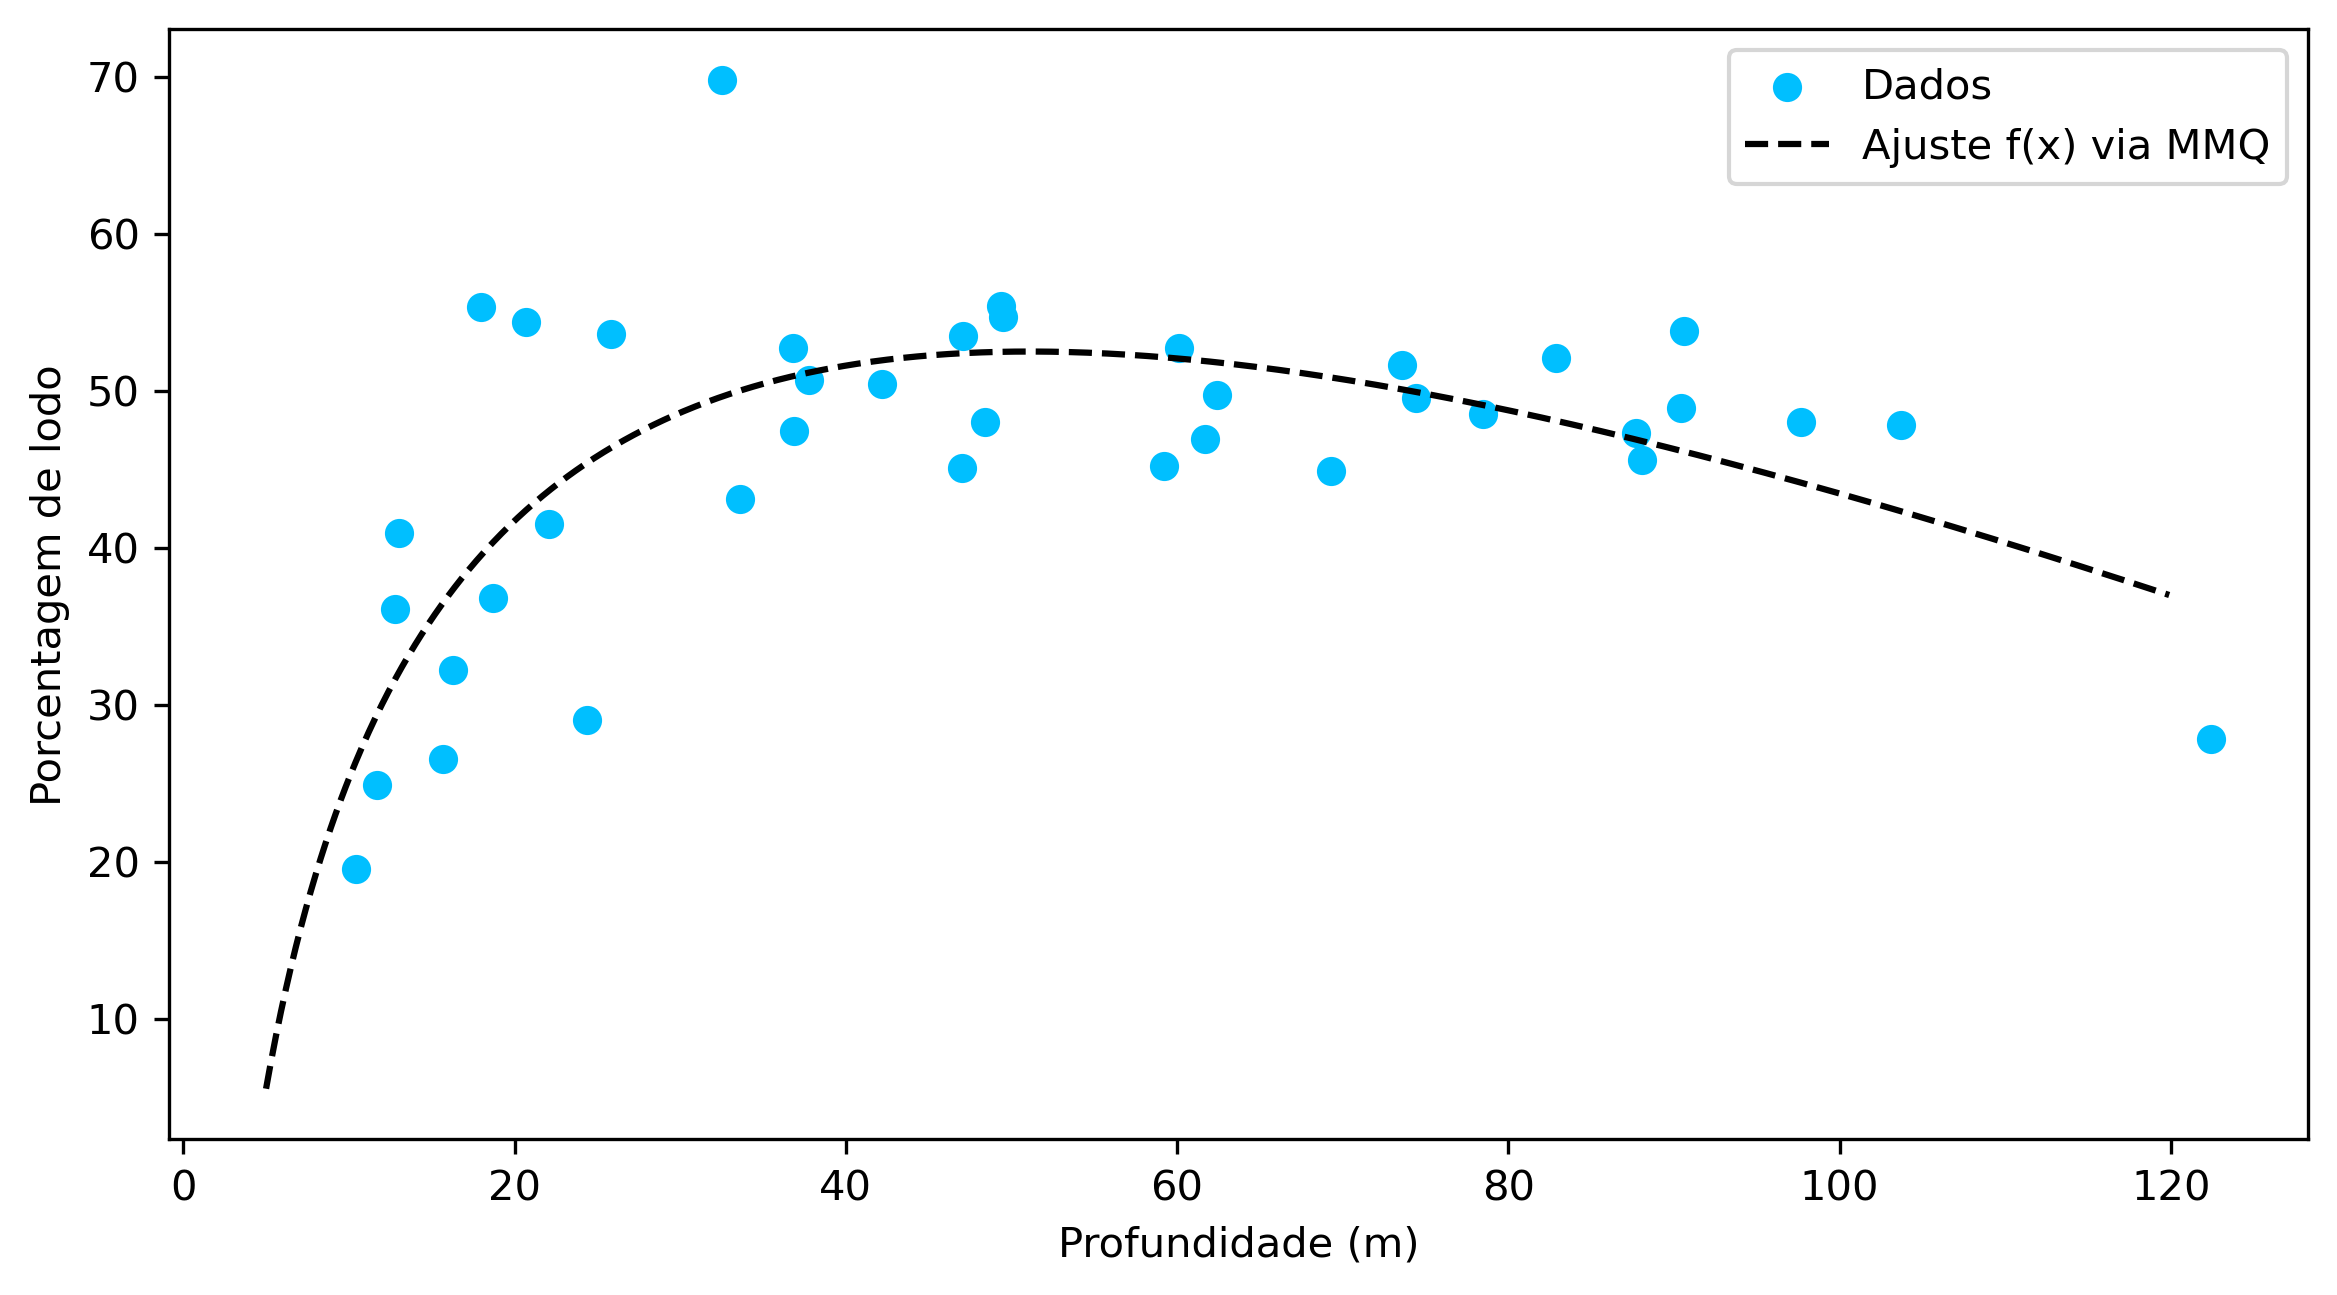

In [93]:
plt.figure(figsize = [9.2,4.9], dpi = 300)
plt.scatter(x,y, color = 'deepskyblue', label = 'Dados')
x_cont = np.arange(5,120,0.1)
plt.plot(x_cont,f(x_cont,alpha,cte_1,x_func,x_square,log), ls = '--', color = 'black', label =  "Ajuste f(x) via MMQ")
plt.xlabel('Profundidade (m)')
plt.ylabel('Porcentagem de lodo')
plt.legend()
plt.show()

## Verificação pela biblioteca scipy:

In [101]:
def func_scp(x,a,b,c,d):
    return a + b*x + c*(x**2) + d*np.log10(x)

In [106]:
fit_param, cov_param = curve_fit(func_scp,x,y)
print(fit_param)

[-4.47394877e+01 -6.72325875e-01  1.98052746e-04  7.67175653e+01]


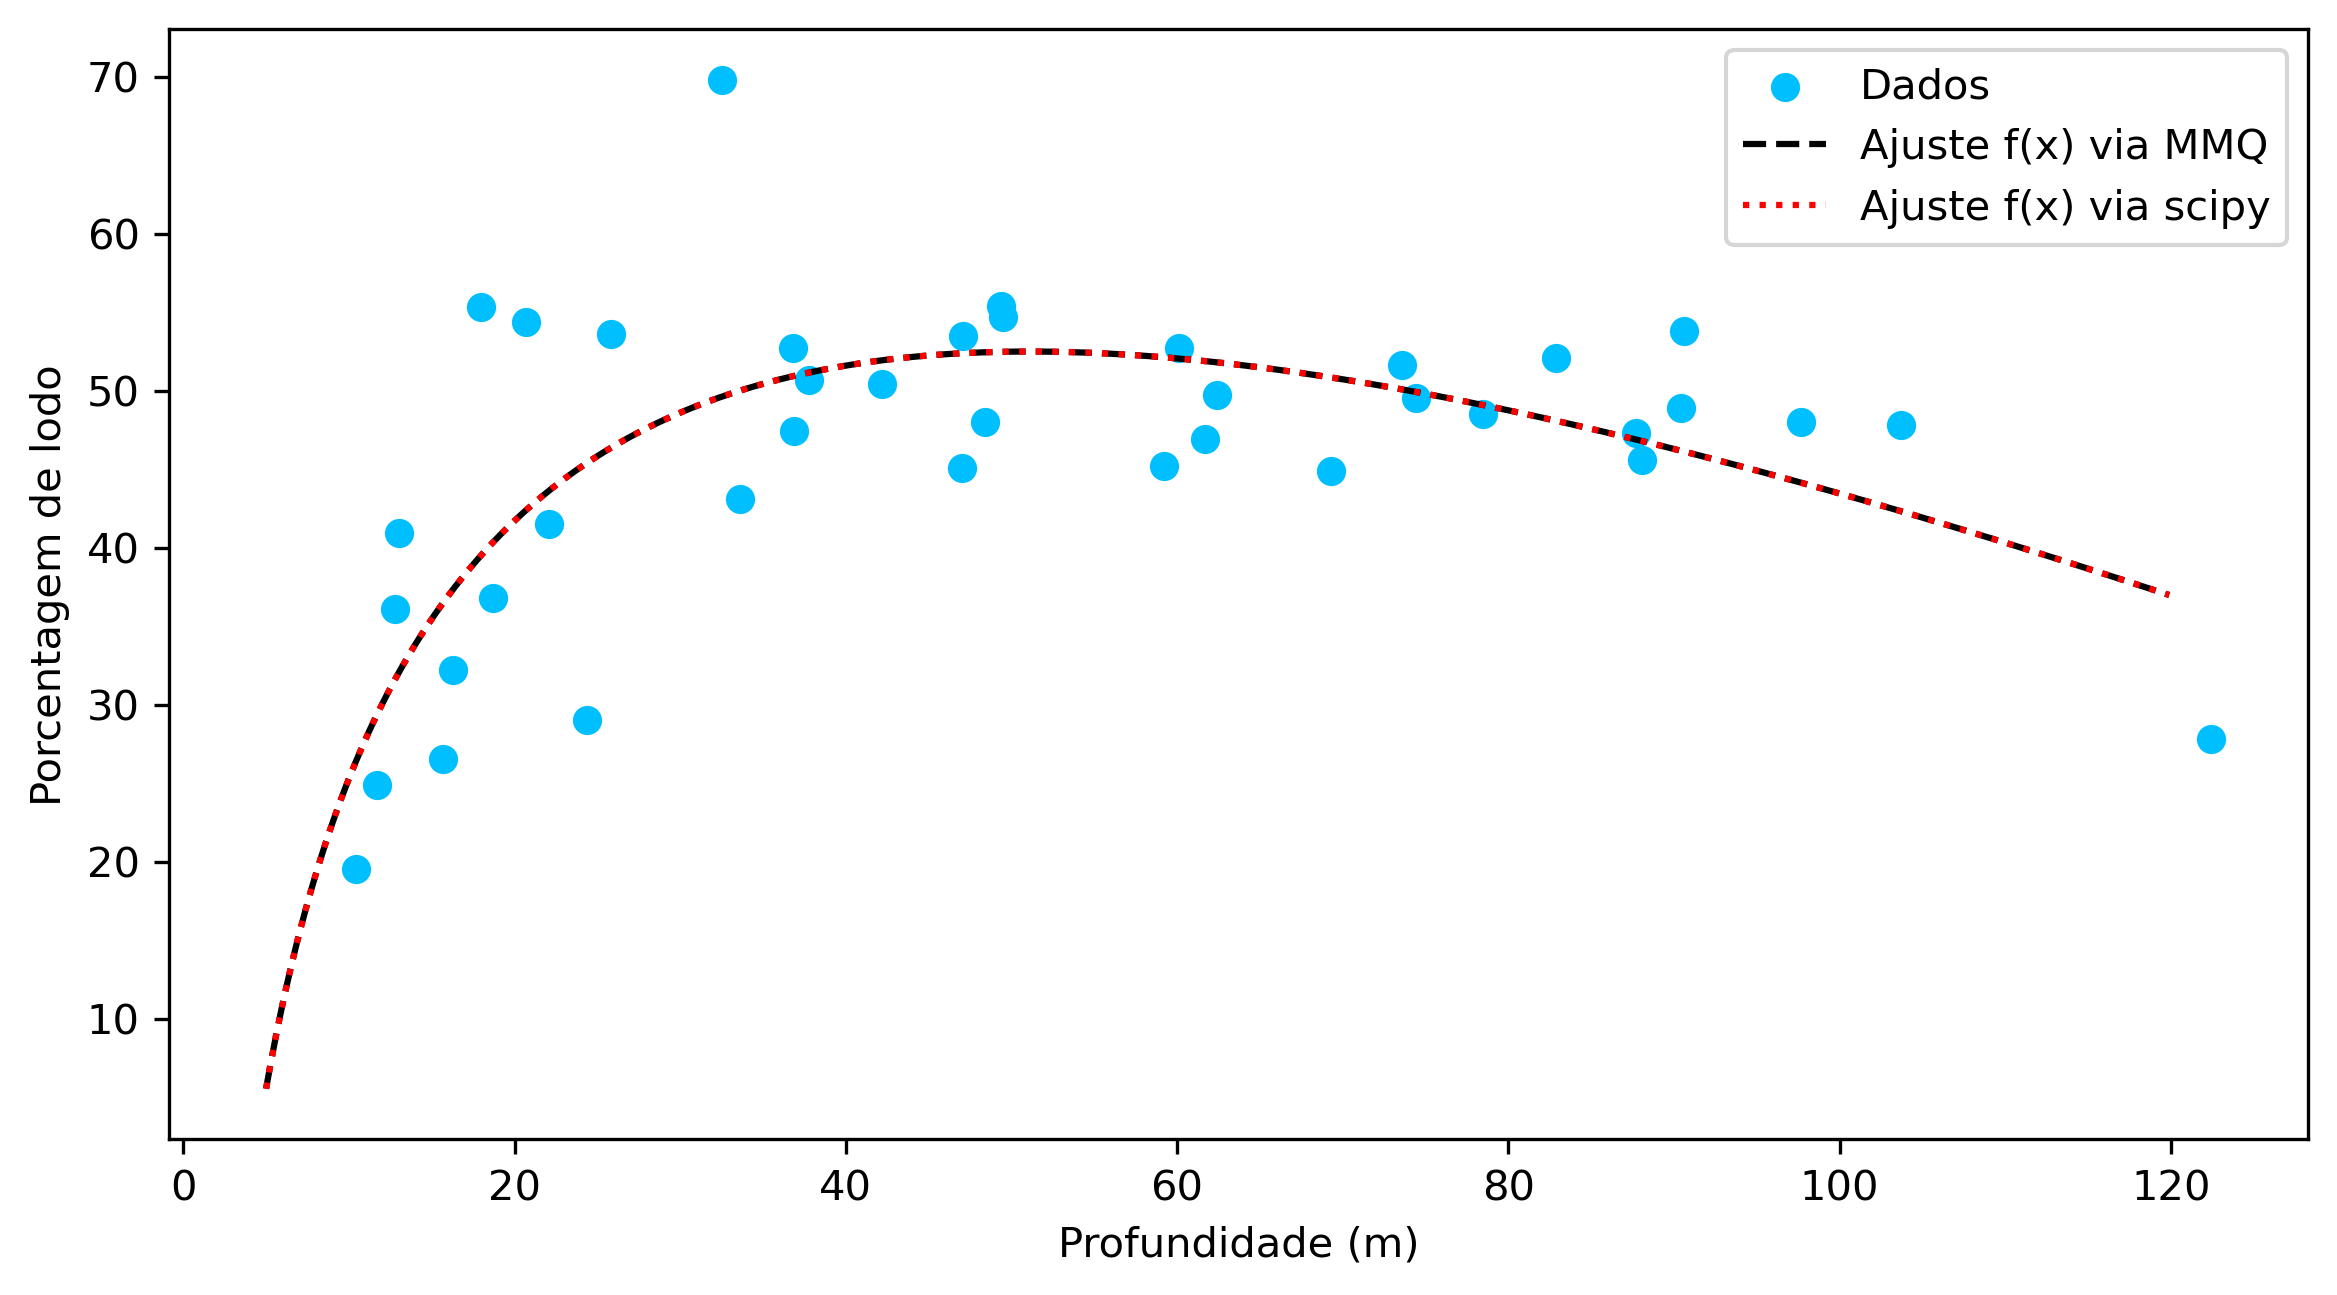

In [118]:
plt.figure(figsize = [9.2,4.9], dpi = 300)
plt.scatter(x,y, color = 'deepskyblue', label = 'Dados')
x_cont = np.arange(5,120,0.1)
plt.plot(x_cont,f(x_cont,alpha,cte_1,x_func,x_square,log), ls = '--', color = 'black', label =  "Ajuste f(x) via MMQ")
plt.plot(x_cont,f(x_cont,fit_param,cte_1,x_func,x_square,log), ls = ':', color = 'red', label =  "Ajuste f(x) via scipy")
plt.xlabel('Profundidade (m)')
plt.ylabel('Porcentagem de lodo')
plt.legend()
plt.show()